In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", context="talk")


In [2]:
## Read all files
df_prior_research = pd.read_csv('../data/empirical_data/prior_research.csv')

In [3]:
# Some useful function definitions

def centralized(n,omega):
    w = (1-omega)*np.ones(n)/n
    w[0]+=omega
    return w

def decentralized(n):
    w = np.ones(n)/n
    return w

def return_Ω(signals, truth, n_samples, n_agents,omega):
    Ω = 0
    centralized_w = centralized(n_agents, omega)
    decentralized_w = decentralized(n_agents)
    
    for i in range(n_samples):
        signal = np.asarray(random.choices(signals,k=n_agents))
        
        decentralized_SAE = np.abs(decentralized_w@signal - truth)
        centralized_SAE  = np.abs(centralized_w@signal - truth)
        
        if decentralized_SAE > centralized_SAE:
            Ω+=1/n_samples
    return Ω

In [4]:
# Calculate Omega

n_samples = 10000
#agents = 40

all_tasks = pd.DataFrame(columns=["task_id","study", "theta", "Omega_hat", "omega","n_agents"])

omegas = [0.1,1/3,2/3,1]
n_agents_range = np.linspace(5,50,4).astype(int)

for idx,task_id in enumerate(df_prior_research['task_id'].unique()):
    for omega in omegas:
        for n_agents in n_agents_range:
            df_temp = df_prior_research[df_prior_research['task_id']==task_id]

            signals = df_temp['pre_influence'].dropna().values
            theta = df_temp['pre_influence'].dropna().values[0]
            #print(theta)
            Omega_hat = return_Ω(signals=signals, truth=theta,
                                 n_samples=n_samples,
                                 n_agents=n_agents,
                                 omega=omega)

            all_tasks = all_tasks.append({
                "task_id": task_id,
                "study": df_temp['study'].dropna().values[0],
                "theta": theta,
                "Omega_hat": Omega_hat,
                "omega": omega,
                "omega_as_frac": str(omega)[0:4],
                "n_agents": n_agents
            },ignore_index = True)

In [5]:
pd.set_option('display.max_rows', None)
#all_tasks.sort_values("Omega_hat")

In [6]:
all_tasks.to_csv('../data/empirical_data/prior_tasks_with_omega_robsutness.csv',index=False)
main_tasks = all_tasks[((all_tasks.omega_as_frac=="0.33") 
           & (all_tasks.n_agents==35))
         ][['task_id', 'study','theta','Omega_hat']]
main_tasks.to_csv('../data/empirical_data/prior_tasks_with_omega.csv',index=False)

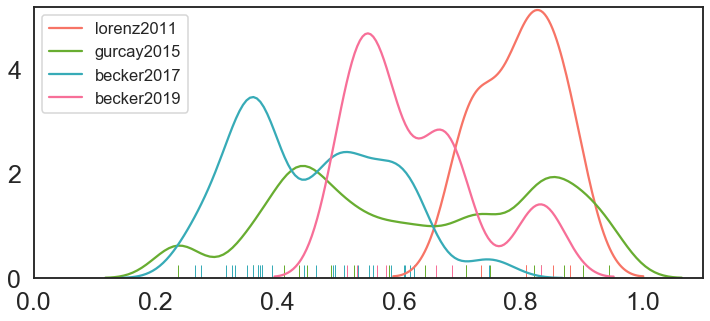

In [17]:
colors = ['#f77466', '#68ad31', '#37abb7', '#f76f98']
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
for i, study in enumerate(main_tasks.study.unique()):
    sns.kdeplot(main_tasks[main_tasks.study==study].Omega_hat, color=colors[i], bw=0.04, label=study,
                ax=ax)
    sns.rugplot(main_tasks[main_tasks.study==study].Omega_hat,colors=colors[i], ax=ax);
    
ax.set_ylim(0,5.2)
ax.set_xlim(0,1.1)
ax.tick_params(labelsize=25)
plt.savefig('./omega_hist.pdf', bbox_inches='tight')